In [1]:
import numpy as np
import torch
import torch.nn as nn
import timm
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.nn import MultiheadAttention
import torch.nn.functional as F
import copy
from torch.nn.init import xavier_uniform_
from torch.nn.init import constant_
import math, random
from torch.utils.data import Dataset, DataLoader
from skimage import exposure
from torch.cuda.amp import autocast, GradScaler
import wandb
import time
from sklearn.metrics import f1_score,roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc
from collections import OrderedDict

In [ ]:
from torchsummary import summary

In [4]:
from sklearn.model_selection import train_test_split

In [2]:
train_split = np.load('../notebooks-mimic/data/train_data_mimic_item_new.npy', allow_pickle=True)
val_split = np.load('../notebooks-mimic/data/val_data_mimic_item_new.npy',allow_pickle=True)
test_split = np.load('../notebooks-mimic/data/test_data_mimic_item_new.npy',allow_pickle=True)

In [9]:
len(train_split_small)

48343

In [3]:
train_split = [item for item in train_split if 1 in item[2][[1,3,8]]]
val_split = [item for item in val_split if 1 in item[2][[1,3,8]]]
test_split = [item for item in test_split if 1 in item[2][[1,3,8]]]

In [5]:
train_split_small, _ = train_test_split(train_split, test_size = 0.7, random_state = 42)

In [ ]:
  #[2,4,5,6,10,11,12]
im = [item for item in train_split_small if 1 in item[2][[2,4,5,6,10,11,12]]]  

In [ ]:
new_im = []

for item in im:
    for _ in range(30):
        new_im.append(item)

In [6]:
class XrayDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths
        self.xray_transforms = transforms.Compose([
                    # transforms.AutoAugment(),
                    # transforms.Normalize(mean=[0.5], std=[0.5]),
                    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
                    transforms.RandomApply([transforms.ColorJitter(brightness =0.3, contrast =0.3)], p=0.7),
                    transforms.RandomApply([transforms.GaussianBlur(kernel_size=23)], p=0.5),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    


            ])
    
    
    def __len__(self):
        return len(self.paths)
        
    def __getitem__(self, idx):
        xray_path = self.paths[idx][0][0]
        label = self.paths[idx][2]
        label_tensor = self._preprocess_label(label)
        xray1, xray2=self._preprocess_xray(xray_path)
        return xray1, xray2, label_tensor
    
    def _preprocess_label(self,label):
        label = label[[1,3,8]].astype(float)
        # label_tensor = torch.tensor(label, dtype=torch.float32)
        return torch.tensor(label)
        
    def _preprocess_xray(self, x):
        x = Image.open(x)
        x = x.convert('L')
        x = x.resize((224,224))
        x = np.array(exposure.equalize_adapthist(x/np.max(x)))
        x = x *255 
        x = x.astype(np.uint8)
        x = Image.fromarray(x)
        x1 = transforms.ToTensor()(x)
        x2 = self.xray_transforms(x)
        return torch.cat([x1,x1,x1], dim = 0), torch.cat([x2,x2,x2], dim = 0)


train = XrayDataset(train_split_small)
val = XrayDataset(val_split)
test = XrayDataset(test_split)

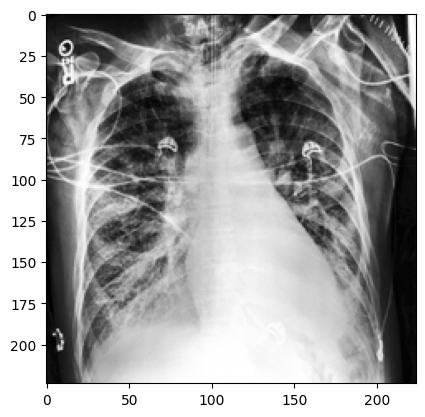

In [12]:
plt.imshow(train[1][0].permute(1,2,0).numpy())

In [ ]:
len(train_split_small)

In [ ]:
# im = Image.open(train[1000][0])
# im = im.resize((224,224))
# im = np.array(im)
# im = np.stack((im,)*3, axis=-1)
# im = Image.fromarray(im)   
train[0][0].shape

In [ ]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    # transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [ ]:
t_im = transform(im)

In [21]:
class CustomMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super(CustomMultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        self.scaling = self.head_dim ** -0.5

        self.q_proj = nn.Linear(embed_dim, embed_dim, bias = False)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias = False)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias = False)
        
        self.out_proj1 = nn.Linear(embed_dim, embed_dim, bias = False)
        self.out_proj2 = nn.Linear(embed_dim, embed_dim, bias = False)

        self.dropout = nn.Dropout(dropout)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.q_proj.weight)
        # nn.init.constant_(self.q_proj.bias, 0)
        nn.init.xavier_uniform_(self.k_proj.weight)
        # nn.init.constant_(self.k_proj.bias, 0)
        nn.init.xavier_uniform_(self.v_proj.weight)
        # nn.init.constant_(self.v_proj.bias, 0)
        nn.init.xavier_uniform_(self.out_proj1.weight)
        nn.init.xavier_uniform_(self.out_proj2.weight)
        # nn.init.constant_(self.out_proj.bias, 0)

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None):
        tgt_len, src_len, bsz, embed_dim = query.size(-3), key.size(-3), query.size(-2), query.size(-1)
        # Linear projections
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(value)

        q = q.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)
                                                         
        q = q * self.scaling

        # Dot product of queries and keys
        attn_output_weights = torch.matmul(q, k.transpose(-2, -1))

        if attn_mask is not None:
            attn_output_weights += attn_mask

        # Apply softmax to get attention output weights
        attn_output_weights = F.softmax(attn_output_weights, dim=-1)

        # Inverse attention output
        inverse_attn_output_weights = 1 - attn_output_weights
        # print(f'inverse attn output: {inverse_attn_output_weights}')
        # Apply dropout
        attn_output_weights = self.dropout(attn_output_weights)

        # Attention output
        attn_output = torch.matmul(attn_output_weights, v)

        attn_output = attn_output.transpose(-3,-2)
        attn_output = attn_output.reshape(tgt_len, bsz, embed_dim)
        attn_output = self.out_proj1(attn_output)

        # Inverse attention output
        # inverse_attn_output_weights = 1 - attn_output_weights
        inverse_attn_output = torch.matmul(inverse_attn_output_weights, v)
        inverse_attn_output = inverse_attn_output.transpose(-3,-2)
        inverse_attn_output = inverse_attn_output.reshape(tgt_len, bsz, embed_dim)
        inverse_attn_output = self.out_proj2(inverse_attn_output)

        return attn_output, inverse_attn_output, attn_output_weights, inverse_attn_output_weights

In [ ]:
CustomMultiheadAttention(768, 12, dropout = 0.1)(torch.randn(13, 1, 768), torch.randn(196, 1, 768), torch.randn(196, 1, 768))[0].shape

In [8]:
xray_state_dict = torch.load('../notebooks-mimic/saved_models/multi_modal_cl/best_model_weights_pretraining_multiModal_xray_batch256_epoch60_lmdb120hr.pth')
# xray_state_dict = torch.load('../notebooks-mimic/saved_models/best_model_weights_pretraining_mimic.pth')
state_dict_xray = OrderedDict()
for k, v in xray_state_dict.items():
    if "encoder_q" in k:
        # if "projector" not in k:
        name = k[20:] # remove the "module." prefix
        # else:
        #     name = k
            # print(k)
        state_dict_xray[name] = v
    # if "projector" in k:
    #     name = k
    #     state_dict_xray[name] = v

In [8]:
model_name = 'vit_base_patch16_224'
encoder = timm.create_model(model_name, pretrained=True)
encoder.head = nn.Identity()

In [10]:
encoder.load_state_dict(state_dict_xray)

<All keys matched successfully>

In [ ]:
blk = encoder.get_intermediate_layers(torch.randn(1,3,224,224), 12)[11]

In [ ]:
out = encoder.norm(blk)

In [22]:
class TransformerEncoder(nn.Module):
    def __init__(self, encoder, num_layers = 12):
        super().__init__()
        self.encoder = encoder
        self.n = num_layers
        self.num_layers = num_layers - 1
        self.layer_norm = encoder.norm
    
    def forward(self, x):
        out = self.encoder.get_intermediate_layers(x, self.n)
        out = out[self.num_layers]
        out = self.layer_norm(out)
        return out 
    
    def get_intermediate(self, x):
        out = self.encoder.get_intermediate_layers(x, self.n)
        return out[:self.num_layers]
        

class TransformerDecoder(nn.Module):
    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate

    def forward(self, tgt, memory, pos, query_pos):
        
        output = tgt

        intermediate = []
        tgt_attn_layers = []
        useless_attn_layers = []
        for layer in self.layers:
            output, useless, tgt_attn, useless_attn = layer(output, memory, pos, query_pos)
            tgt_attn_layers.append(tgt_attn)
            useless_attn_layers.append(useless_attn)
            if self.return_intermediate:
                intermediate.append(self.norm(output))
                

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)

        if self.return_intermediate:
            return torch.stack(intermediate)

        return output.unsqueeze(0), useless.unsqueeze(0), tgt_attn_layers, useless_attn_layers
    
class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu"):
        super().__init__()
        self.slf_attn = MultiheadAttention(d_model, nhead, dropout = dropout)
        self.multihead_attn = CustomMultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.linear3 = nn.Linear(dim_feedforward, d_model)
        self.linear4 = nn.Linear(d_model, dim_feedforward)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.norm4 = nn.LayerNorm(d_model)
        self.norm5 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.dropout4 = nn.Dropout(dropout)
        self.dropout5 = nn.Dropout(dropout)
        self.dropout6 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.activation1 = _get_activation_fn(activation)


    def with_pos_embed(self, tensor, pos):
        # print(f'shapes: {tensor.shape}, {pos.shape}')
        return tensor if pos is None else tensor + pos

    def forward(self, tgt, memory, pos=None, query_pos=None):
        q=k=self.with_pos_embed(tgt, query_pos)
        
        tgt2, sim_mat = self.slf_attn(query=q, key=k, value=tgt)
        tgt = tgt+self.dropout(tgt2)
        tgt = self.norm1(tgt)
        
        tgt2, useless, tgt_attn, useless_attn = self.multihead_attn(query=self.with_pos_embed(tgt, query_pos),
                                key=self.with_pos_embed(memory, pos),
                                value=memory)

        
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)

        # print(f'useless: {useless}')
        useless = useless + self.norm4(self.dropout4(useless))
        useless = self.linear3(self.dropout5(self.activation1(self.linear4(useless))))
        useless = useless + self.dropout6(useless)
        useless = self.norm5(useless)
        # print(f'useless after norm: {useless}')


        return tgt, useless, tgt_attn, useless_attn




def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def _get_activation_fn(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return F.relu
    if activation == "gelu":
        return F.gelu
    if activation == "glu":
        return F.glu
    raise RuntimeError(F"activation should be relu/gelu, not {activation}.")   
    
    

In [42]:
class Transformer(nn.Module):
    def __init__(self, encoder, d_model = 768, nhead = 4, num_encoder_layers = 12, 
                 num_decoder_layers = 4, dropout = 0.2):
        super().__init__()
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dropout = dropout 
        self.nhead = nhead
        self.d_model = d_model
        model_name = 'vit_base_patch16_224'
        self.encoder_model = encoder
        for param in self.encoder_model.parameters():
            param.requires_grad=False
        self.encoder = TransformerEncoder(self.encoder_model, self.num_encoder_layers)
        self.decoder_layer = TransformerDecoderLayer(self.d_model, self.nhead)
        self.decoder = TransformerDecoder(self.decoder_layer, self.num_decoder_layers)
        # self.pos_embed_decoder = nn.Parameter(torch.zeros(196, 1, d_model))
        self.pos_embed_decoder = None
        
    def forward(self, image, query_embed):
        bs = image.shape[0]
        query_embed = query_embed.unsqueeze(1).repeat(1, bs, 1)
        
        memory = self.encoder(image)
        memory = memory.permute(1,0,2)
        query = torch.zeros_like(query_embed)
        # print(query.shape)
        # print(query)

        causal, non_causal, attn1, attn2 = self.decoder(query, memory, pos = self.pos_embed_decoder, 
                                          query_pos=query_embed)
        
        return causal.transpose(1,2), non_causal.transpose(1,2), attn1, attn2

In [24]:
class GroupWiseLinear(nn.Module):
    # could be changed to:
    # output = torch.einsum('ijk,zjk->ij', x, self.W)
    # or output = torch.einsum('ijk,jk->ij', x, self.W[0])
    def __init__(self, num_class, hidden_dim, bias=True):
        super().__init__()
        self.num_class = num_class
        self.hidden_dim = hidden_dim
        self.bias = bias

        self.W = nn.Parameter(torch.Tensor(1, num_class, hidden_dim))
        if bias:
            self.b = nn.Parameter(torch.Tensor(1, num_class))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.W.size(2))
        for i in range(self.num_class):
            self.W[0][i].data.uniform_(-stdv, stdv)
        if self.bias:
            for i in range(self.num_class):
                self.b[0][i].data.uniform_(-stdv, stdv)

    def forward(self, x):
        # x: B,K,d
        x = (self.W * x).sum(-1)
        if self.bias:
            x = x + self.b
        return x
    
class GroupWiseLinear2(nn.Module):
    # could be changed to:
    # output = torch.einsum('ijk,zjk->ij', x, self.W)
    # or output = torch.einsum('ijk,jk->ij', x, self.W[0])
    def __init__(self, num_class, hidden_dim, bias=True):
        super().__init__()
        self.num_class = num_class
        self.hidden_dim = hidden_dim
        self.bias = bias

        self.W = nn.Parameter(torch.Tensor(1, num_class, hidden_dim))
        if bias:
            self.b = nn.Parameter(torch.Tensor(1, num_class))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.W.size(2))
        for i in range(self.num_class):
            self.W[0][i].data.uniform_(-stdv, stdv)
        if self.bias:
            for i in range(self.num_class):
                self.b[0][i].data.uniform_(-stdv, stdv)

    def forward(self, x):
        # x: B,K,d
        x = (self.W * x).sum(-1)
        if self.bias:
            x = x + self.b
        return x

In [ ]:
encoder

In [43]:
transformer = Transformer(encoder)

In [ ]:
query_input = nn.Embedding(3, 768).weight

In [ ]:
transformer(train[0][0].unsqueeze(0), query_input)[1].shape

In [44]:
class Causal(nn.Module):
    def __init__(self, num_classes, transformer):
        super().__init__()
        self.num_classes = num_classes
        self.transformer = transformer
        hidden_dim = transformer.d_model
        self.query_embed = nn.Embedding(num_classes, hidden_dim)
        self.fc = GroupWiseLinear(num_classes, hidden_dim, bias=True)
        self.fc_cat = GroupWiseLinear2(num_classes, hidden_dim*2, bias=True)
        
    def forward(self, x):
        query_input = self.query_embed.weight
        cs, non_cs, cs_attn, useless_attn = self.transformer(x, query_input)#[0], self.transformer(x, query_input)[1]
        cs, non_cs = cs[-1], non_cs[-1]
        # print(f'cs: {cs}')
        # print(f'non_cs: {non_cs}')

        l = [i for i in range(cs.shape[0])]
        random.shuffle(l)
        random_idx = torch.tensor(l)
        
        mixed_cs = torch.cat((non_cs[random_idx], cs), dim=2)
        # print(f'mixed cs before fc: {mixed_cs}')
        mixed_out = self.fc_cat(mixed_cs)
        out = self.fc(cs)

        # print(f'out: {out}')
        # print(f'mixed: {mixed_out}')
        
        return out, mixed_out, cs_attn, useless_attn

In [45]:
causal_model = Causal(3, transformer)

In [29]:
for name, param in causal_model.named_parameters():
    print(name, param.requires_grad)

transformer.encoder_model.cls_token False
transformer.encoder_model.pos_embed False
transformer.encoder_model.patch_embed.proj.weight False
transformer.encoder_model.patch_embed.proj.bias False
transformer.encoder_model.blocks.0.norm1.weight False
transformer.encoder_model.blocks.0.norm1.bias False
transformer.encoder_model.blocks.0.attn.qkv.weight False
transformer.encoder_model.blocks.0.attn.qkv.bias False
transformer.encoder_model.blocks.0.attn.proj.weight False
transformer.encoder_model.blocks.0.attn.proj.bias False
transformer.encoder_model.blocks.0.norm2.weight False
transformer.encoder_model.blocks.0.norm2.bias False
transformer.encoder_model.blocks.0.mlp.fc1.weight False
transformer.encoder_model.blocks.0.mlp.fc1.bias False
transformer.encoder_model.blocks.0.mlp.fc2.weight False
transformer.encoder_model.blocks.0.mlp.fc2.bias False
transformer.encoder_model.blocks.1.norm1.weight False
transformer.encoder_model.blocks.1.norm1.bias False
transformer.encoder_model.blocks.1.attn.qk

In [25]:
causal_model.transformer.encoder_model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [17]:
layers_xray = list(causal_model.transformer.encoder_model.children())

for param in layers_xray[4][10:].parameters():
    param.requires_grad = True
    
for layer in layers_xray[5:]:
    for param in layer.parameters():
        param.requires_grad = True
        

In [ ]:
summary(causal_model.cuda(), (3,224,224))

In [30]:
causal_model(train[0][0].unsqueeze(0))[1]

tensor([[1.1274, 0.1232, 0.2166]], grad_fn=<AddBackward0>)

In [ ]:
train[0][2].size(0)

In [ ]:
criterion((causal_model(train[0][0].unsqueeze(0))[0]), train[0][2].unsqueeze(0))

In [39]:
class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=2, gamma_pos=0, clip=0.05, eps=1e-5, 
                 disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                with torch.no_grad():
                    # if self.disable_torch_grad_focal_loss:
                    #     torch._C.set_grad_enabled(False)
                    self.xs_pos = self.xs_pos * self.targets
                    self.xs_neg = self.xs_neg * self.anti_targets
                    self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                                self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
                    # if self.disable_torch_grad_focal_loss:
                    #     torch._C.set_grad_enabled(True)
                self.loss *= self.asymmetric_w
            else:
                self.xs_pos = self.xs_pos * self.targets
                self.xs_neg = self.xs_neg * self.anti_targets
                self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                            self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)   
                self.loss *= self.asymmetric_w

        _loss = - self.loss.sum() / x.size(0)
        _loss = _loss / y.size(1) * 1000
        return _loss
    

In [18]:
batch_size = 32
kl = 1 
ce2 = 0.5
lr = 1e-4

In [19]:
criterion = nn.BCEWithLogitsLoss()
# criterion = AsymmetricLossOptimized()
# scaler = GradScaler()
optimizer = torch.optim.AdamW(causal_model.parameters(), lr = lr, weight_decay = 1e-2)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 15, eta_min=1e-5, T_mult = 2)

In [20]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, num_workers=7,
                                           shuffle = True, pin_memory=True) 
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_size, num_workers=7, pin_memory=True) 
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, num_workers=7,pin_memory=True)

In [21]:
wandb.init(
    project = "Causal Learning",
    name = "causal-run-3",
    config = {
        "learning_rate": [1e-4, 1e-5],
        "scheduler": "CosineAnnealingWithWarmRestarts",
        "model": "Vit Encoder + Decoder",
        "dataset": "Mimic",
        "epochs": 100,
        "data": "70k",
        "batch": 32,
        "Mixed Precision": True,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: svthapa. Use `wandb login --relogin` to force relogin


In [46]:
causal_model = causal_model.cuda()

In [36]:
len(train_loader)

2518

In [25]:
def calc_roc_auc(all_labels, all_probs):
    # Calculate ROC AUC for each label
    num_labels = all_labels.shape[1]
    roc_auc_scores = []
    for i in range(num_labels):
        roc_auc = roc_auc_score(all_labels[:, i], all_probs[:, i])
        roc_auc_scores.append(roc_auc)
        # print(f'Label {i} ROC AUC: {roc_auc:.4f}')

    # Calculate macro and micro averaged ROC AUC
    roc_auc_macro = np.mean(roc_auc_scores)
    # print(f'Macro Averaged ROC AUC: {roc_auc_macro:.4f}')

    roc_auc_micro = roc_auc_score(all_labels.ravel(), all_probs.ravel())
    # print(f'Micro Averaged ROC AUC: {roc_auc_micro:.4f}')
    return roc_auc_macro, roc_auc_micro

def plot_roc_curve(all_labels, all_probs, num_labels, save_path='roc_curve.png'):
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))
    
    # Calculate and plot ROC curve for each label
    for i in range(num_labels):
        fpr, tpr, _ = roc_curve(all_labels[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Label {i} (area = {roc_auc:.2f})')
        
    # Calculate and plot micro-average ROC curve
    fpr, tpr, _ = roc_curve(all_labels.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='deeppink', lw=2, linestyle=':', label=f'Micro-average ROC curve (area = {roc_auc:.2f})')
    
    # Plot the random chance line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Add labels and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    # Save the plot
    plt.savefig(save_path)
    plt.close()
    
def plot_precision_recall_curve(y_true, y_probs, save_path):
    n_classes = y_true.shape[1]
    plt.figure(figsize=(10, 8))
    
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        avg_precision = average_precision_score(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f'Label {i} (area = {avg_precision:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')
    plt.grid(alpha=0.2)
    plt.savefig(save_path)
    plt.close()
    
def precision_recall_per_label(true_labels, predictions):
    """
    Calculate precision and recall for each label.
    
    Parameters:
    - true_labels (numpy array): Ground truth labels.
    - predictions (numpy array): Predicted labels.
    
    Returns:
    - precisions (list): List of precisions for each label.
    - recalls (list): List of recalls for each label.
    """
    
    # Check if dimensions match
    if true_labels.shape != predictions.shape:
        raise ValueError("Dimensions of true labels and predictions do not match.")
    
    num_labels = true_labels.shape[1]
    precisions = []
    recalls = []
    for i in range(num_labels):
        TP = np.sum((true_labels[:, i] == 1) & (predictions[:, i] == 1))
        FP = np.sum((true_labels[:, i] == 0) & (predictions[:, i] == 1))
        FN = np.sum((true_labels[:, i] == 1) & (predictions[:, i] == 0))
        
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls

def accuracy_per_label(true_labels, predictions):
    """
    Calculate accuracy for each label.

    Parameters:
    - true_labels (numpy array): Ground truth labels.
    - predictions (numpy array): Predicted labels.

    Returns:
    - accuracies (list): List of accuracies for each label.
    """

    # Check if dimensions match
    if true_labels.shape != predictions.shape:
        raise ValueError("Dimensions of true labels and predictions do not match.")

    # Calculate accuracies
    num_labels = true_labels.shape[1]
    accuracies = []
    for i in range(num_labels):
        correct_predictions = np.sum(true_labels[:, i] == predictions[:, i])
        total_instances = true_labels.shape[0]
        accuracy = correct_predictions / total_instances
        accuracies.append(accuracy)

    return accuracies

In [23]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [28]:
# torch.autograd.set_detect_anomaly(True)
epochs = 100
best_roc = -999
early_stopping = EarlyStopping(patience = 3)
for epoch in range(epochs):
    print(f"\nEpoch [{epoch + 1}/{epochs}]")
    print("-" * 50)
    stime = time.time()
    causal_model.train()
    tr_loss = 0
    all_preds = torch.empty((0, 3)).cuda()
    all_labels = torch.empty((0, 3)).cuda()
    all_probs = torch.empty((0, 3)).cuda()
    for step, (image1, image2, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        images, labels = image2.cuda(), labels.cuda()
        
        # with autocast():
        cs, non_cs = causal_model(images)
        uniform_target = torch.ones_like(non_cs, dtype=torch.float).to('cuda') / 3
        loss1 = criterion(cs, labels)
        loss2 = F.kl_div(F.log_softmax(non_cs, dim=1), uniform_target, reduction='batchmean')
        loss3 = criterion(non_cs, labels)
        loss = loss1 + kl * loss2 + ce2 * loss3
        prob = torch.sigmoid(cs)
        binary_preds = (prob >= 0.4).float() 
        
        all_preds = torch.cat((all_preds, binary_preds), 0)
        all_labels = torch.cat((all_labels, labels), 0)
        all_probs = torch.cat((all_probs, prob), 0)
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        loss.backward()
        optimizer.step()
        tr_loss += loss
        
        if step % 1000 == 0:
            print(f'Step [{step+1}/{len(train_loader)}]\t train loss: {loss.item():.4f}')
    all_labels = all_labels.detach().cpu().numpy()
    all_probs = all_probs.detach().cpu().numpy()  
    all_preds = all_preds.detach().cpu().numpy()
    
    accuracies_train = accuracy_per_label(all_labels, all_preds)
    roc_auc_macro_train, roc_auc_micro_train = calc_roc_auc(all_labels, all_probs)
    
    print("\nMetrics after Training:")
    print("-" * 30)
    for i, acc_train in enumerate(accuracies_train):
        print(f"Label {i}: Accuracy: {acc_train:.4f}, Roc-Auc: {roc_auc_macro_train:.4f}")
    print("-" * 40)
    # scheduler.step()
    
    causal_model.eval()
    with torch.no_grad():
        val_loss = 0
        all_labels_val = torch.empty((0, 3)).cuda()
        all_probs_val = torch.empty((0, 3)).cuda()
        all_preds_val = torch.empty((0, 3)).cuda()
        for step, (image1, image2, labels) in enumerate(val_loader):
            images, labels = image1.cuda(), labels.cuda()
            cs, non_cs = causal_model(images)
            uniform_target = torch.ones_like(non_cs, dtype=torch.float).to('cuda') / 3
            loss1 = criterion(cs, labels)
            loss2 = F.kl_div(F.log_softmax(non_cs, dim=1), uniform_target, reduction='batchmean')
            loss3 = criterion(non_cs, labels)
            loss = loss1 + kl * loss2 + ce2 * loss3
            prob_val = torch.sigmoid(cs)
            binary_preds_val = (prob_val >= 0.4).float() 
            
            all_preds_val = torch.cat((all_preds_val, binary_preds_val), 0)
            all_labels_val = torch.cat((all_labels_val, labels), 0)
            all_probs_val = torch.cat((all_probs_val, prob_val), 0)
                
            val_loss += loss
        all_labels_val = all_labels_val.detach().cpu().numpy()
        all_probs_val = all_probs_val.detach().cpu().numpy()  
        all_preds_val = all_preds_val.detach().cpu().numpy()
        
        accuracies_val = accuracy_per_label(all_labels_val, all_preds_val)
        roc_auc_macro, roc_auc_micro = calc_roc_auc(all_labels_val, all_probs_val)
        
        if roc_auc_macro > best_roc:
            torch.save(causal_model.state_dict(), 'saved_models/best_model.pth')
        print("\nMetrics after Validation:")
        print("-" * 30)
        for i, acc_val in enumerate(accuracies_val):
            print(f"Label {i}: Accuracy: {acc_val:.4f}, Roc-Auc: {roc_auc_macro:.4f}")
        print("-" * 40)
        
        plot_roc_curve(all_labels_val, all_probs_val, all_labels_val.shape[1], save_path=f'plots/roc_curve_val_epoch_{epoch}.png')
        plot_precision_recall_curve(all_labels_val, all_probs_val, save_path=f'plots/precision_recall_curve_val_epoch_{epoch}.png')
        
    print(f'Epoch {epoch}/{epochs} \t Train Loss: {tr_loss/len(train_loader):.4f} \t Val Loss: {val_loss/len(val_loader):.4f} \t Roc Auc(macro/micro): {roc_auc_macro:.4f}, {roc_auc_micro:.4f}')
    
    print(f'time taken: {time.time() - stime}')
    


Epoch [1/100]
--------------------------------------------------
Step [1/1511]	 train loss: 0.8927
Step [1001/1511]	 train loss: 0.8947

Metrics after Training:
------------------------------
Label 0: Accuracy: 0.6446, Roc-Auc: 0.5016
Label 1: Accuracy: 0.7494, Roc-Auc: 0.5016
Label 2: Accuracy: 0.5122, Roc-Auc: 0.5016
----------------------------------------

Metrics after Validation:
------------------------------
Label 0: Accuracy: 0.6426, Roc-Auc: 0.5532
Label 1: Accuracy: 0.7438, Roc-Auc: 0.5532
Label 2: Accuracy: 0.5040, Roc-Auc: 0.5532
----------------------------------------
Epoch 0/100 	 Train Loss: 0.9650 	 Val Loss: 0.9682 	 Roc Auc(macro/micro): 0.5532, 0.6339
time taken: 658.9227759838104

Epoch [2/100]
--------------------------------------------------
Step [1/1511]	 train loss: 0.9783


KeyboardInterrupt: 

Label Cardiomegaly: 35.24%
Label Edema: 25.14%
Label No Finding: 51.24%


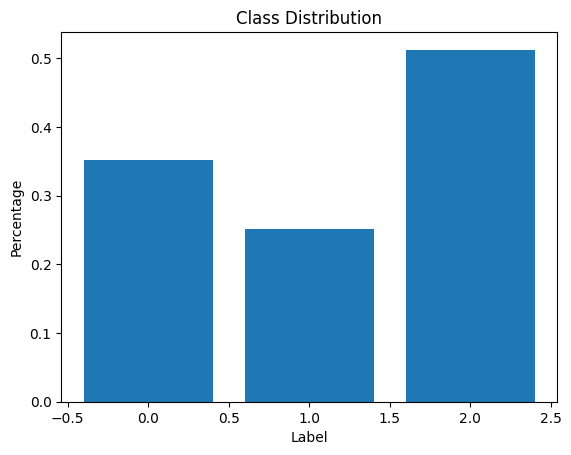

In [32]:
# Extract label arrays and stack them into a single numpy array
label_arrays = [item[2][[1,3,8]] for item in train_split_small]
all_labels = np.vstack(label_arrays)

label_names = [#'Atelectasis', 
               'Cardiomegaly', 
               # 'Consolidation', 
               'Edema', 
               # 'Enlarged Cardiomediastinum', 
               # 'Fracture', 
               # 'Lung Lesion', 
               # 'Lung Opacity', 
               'No Finding', 
               # 'Pleural Effusion', 
               # 'Pleural Other', 
               # 'Pneumonia', 
               # 'Pneumothorax'
             ]

# Calculate label counts
label_counts = np.sum(all_labels, axis=0)

# Calculate percentages for each label
total_data_points = all_labels.shape[0]
percentages = label_counts / total_data_points

# Print the balancing information
for i, percentage in enumerate(percentages):
    print(f"Label {label_names[i]}: {percentage * 100:.2f}%")

# Visualize (Optional)
plt.bar(range(len(label_counts)), percentages)
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.title('Class Distribution')
plt.show()

In [47]:
causal_model.load_state_dict(torch.load('saved_models/best_model.pth'))

<All keys matched successfully>

In [17]:
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

In [48]:
causal_model.eval()

Causal(
  (transformer): Transformer(
    (encoder_model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featu

In [122]:
test[10][2]

tensor([1., 1., 0.], dtype=torch.float64)

In [132]:
attn = causal_model(test[10][0].unsqueeze(0).cuda())[2][-1]

In [135]:
attn = attn.squeeze(0)
attn = attn[:, 0, :]

In [136]:
attn.shape

torch.Size([4, 196])

In [137]:
attn = attn.reshape(4, 14, 14)
attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor = 16, mode = 'nearest')[0].cpu().detach().numpy()

In [138]:
attn = np.min(attn, 0)

In [139]:
norm_attn = (attn - attn.min()) / (attn.max() - attn.min())

In [140]:
img = np.squeeze(np.array(train[1][0].permute(1,2,0).cpu().numpy()))

In [141]:
norm_img = (img - img.min()) / (img.max() - img.min())

/scratch/svthapa/1206278/ipykernel_2576554/38991795.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  heatmap = ax2.imshow(norm_attn, cmap = cm.get_cmap('viridis'), alpha = 0.7)


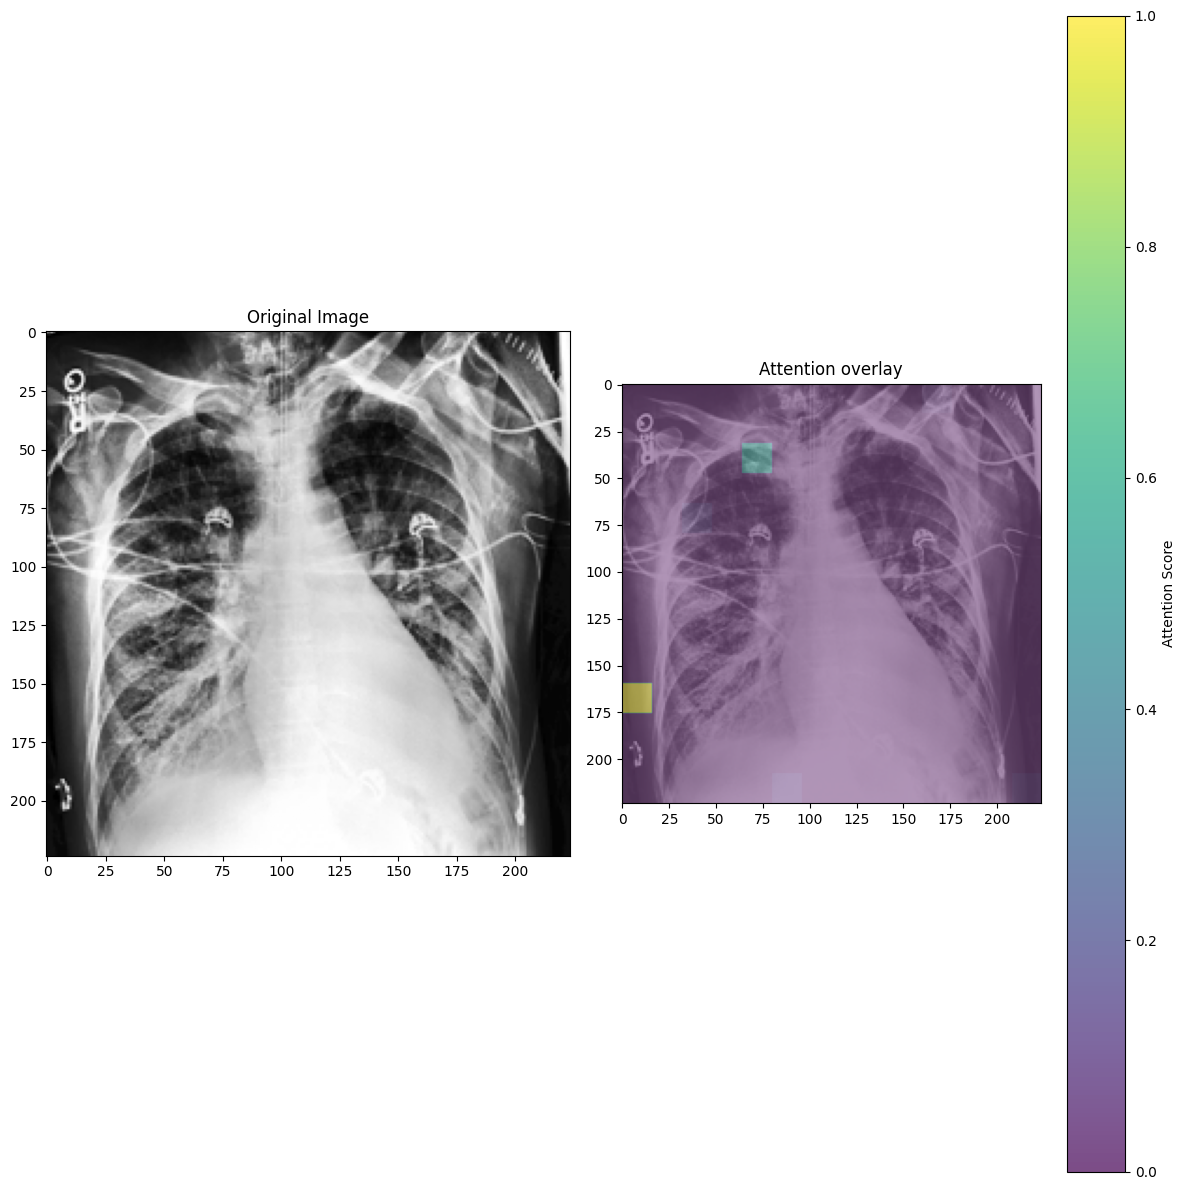

In [142]:
import matplotlib.cm as cm 

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,12))
ax1.imshow(norm_img)
ax1.set_title('Original Image')

heatmap = ax2.imshow(norm_attn, cmap = cm.get_cmap('viridis'), alpha = 0.7)
ax2.imshow(norm_img, alpha = 0.4)
ax2.set_title('Attention overlay')

cbar = plt.colorbar(heatmap, ax=ax2)
cbar.set_label('Attention Score')

plt.tight_layout()
plt.show()